In [1]:
import os
os.chdir('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from ptflops import get_model_complexity_info

from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
from utils import ModelTrainer
from models.models import BasicLSTM
from utils.datasets import EMGO_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# class EMG_dataset(torch.utils.data.Dataset):
#     def __init__(self, csv, lag, n_ahead):
#         self.csv = csv
#         self.lag = lag
#         self.n_ahead = n_ahead

#     def __len__(self):
#         return len(self.csv) - self.lag - self.n_ahead

#     def __getitem__(self, idx):
#         X = self.csv.iloc[idx:idx+self.lag, :4].values
#         Y = self.csv.iloc[idx+self.lag:idx+self.lag+self.n_ahead, 4:].values
        
#         return (torch.Tensor(X), torch.Tensor(Y))



In [3]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=lr), nn.MSELoss(), "Regression",  device, 0, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    if not noPrint:
        print("\nTest Loss:", Trainer.Metrics["Test Loss"], "\nTime to Train:", t1 - t0)
        Trainer.Graph_Metrics()
    
    macs, params = get_model_complexity_info(Trainer.model, (24, 4), as_strings=True, print_per_layer_stat=False, verbose=True)
    Trainer.model.to("cpu")
    
    return Trainer, (macs, params)

,EMG PATH,FRAMES
0,M:/Datasets/shock_walk/processed/2.0mph.csv,1800
1,M:/Datasets/shock_walk/processed/2.5mph.csv,1800
2,M:/Datasets/shock_walk/processed/3.1mph.csv,1800
3,M:/Datasets/shock_walk/processed/Quiet_Stance_...,1800
4,M:/Datasets/shock_walk/processed/StandStop_2mp...,1800


torch.Size([24, 4]) torch.Size([12, 4])
torch.Size([12, 24, 4]) torch.Size([12, 12, 4])


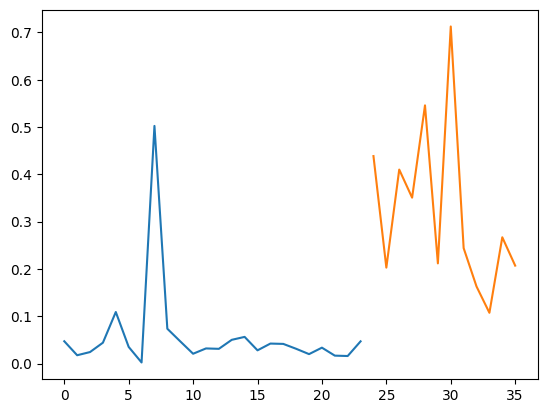

In [5]:
dataset = EMGO_dataset("emg.csv", lag=24, n_ahead=12)
X, Y = dataset.__getitem__(0)
print(X.shape, Y.shape)

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
trainLoader = DataLoader(train_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=True)

for X, Y in trainLoader:
    print(X.shape, Y.shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)
    
    # First Batch
    plt.plot(X[0][:,0])
    plt.plot(y_range, Y[0][:,0])
    break

In [6]:
def test_parameters(EPOCHS=100, lr=0.001):
    
    dataset = EMG_dataset(total, lag=24, n_ahead=12)

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
    
    
    input_size = 4
    hidden_sizes = [64, 96, 128]
    num_layers = [3, 4, 5]
    batch_sizes = [2, 3, 4]
    output_size = train_dataset.dataset.n_ahead
    
    results = []
    trainers = []
    
    for hidden_size in hidden_sizes:
        for num_layer in num_layers:
            for batch_size in batch_sizes:
            
                trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
                validLoader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
                testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

                model = BasicLSTM(input_size, hidden_size, num_layer, output_size)

                Trainer, mp = train_test_model(model, lr, trainLoader, validLoader, testLoader, EPOCHS, noPrint=True)
                trainers.append(Trainer)
                
                test_loss = Trainer.Metrics["Test Loss"]
                results.append(f"Hidden: {hidden_size} | Layers: {num_layer} | Batch Size: {batch_size} | Macs: {mp[0]} | Params: {mp[1]} | Test Loss: {test_loss}")
                print(results[-1])
                               
    results = np.array(results)
    
    return results, trainers

In [11]:
re, T = test_parameters(200)

Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Ba

Hidden: 64 | Layers: 2 | Batch Size: 4 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.06733934581279755
Hidden: 64 | Layers: 2 | Batch Size: 16 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.0748613253235817
Hidden: 64 | Layers: 2 | Batch Size: 32 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.08276855945587158
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.05407020077109337
Hidden: 64 | Layers: 4 | Batch Size: 16 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0663127526640892
Hidden: 64 | Layers: 4 | Batch Size: 32 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.07040233165025711
Hidden: 64 | Layers: 6 | Batch Size: 4 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.07566986978054047
Hidden: 64 | Layers: 6 | Batch Size: 16 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.19122886657714844
Hidden: 64 | Layers: 6 | Batch Size: 32 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.06731513887643814
Hidden: 128 | Layers: 2 | Batch Size: 4 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.04985114932060242
Hidden: 128 | Layers: 2 | Batch Size: 16 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.05833622068166733
Hidden: 128 | Layers: 2 | Batch Size: 32 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.06787940114736557
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.02661198005080223
Hidden: 128 | Layers: 4 | Batch Size: 16 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.04889538139104843
Hidden: 128 | Layers: 4 | Batch Size: 32 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.05771384760737419
Hidden: 128 | Layers: 6 | Batch Size: 4 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19148249924182892
Hidden: 128 | Layers: 6 | Batch Size: 16 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19151681661605835
Hidden: 128 | Layers: 6 | Batch Size: 32 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.05349093675613403
Hidden: 256 | Layers: 2 | Batch Size: 4 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.024070965126156807
Hidden: 256 | Layers: 2 | Batch Size: 16 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.046882450580596924
Hidden: 256 | Layers: 2 | Batch Size: 32 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.05703727528452873
Hidden: 256 | Layers: 4 | Batch Size: 4 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.014045578427612782
Hidden: 256 | Layers: 4 | Batch Size: 16 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.03199911490082741
Hidden: 256 | Layers: 4 | Batch Size: 32 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.05679785832762718
Hidden: 256 | Layers: 6 | Batch Size: 4 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.01443294994533062
Hidden: 256 | Layers: 6 | Batch Size: 16 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.19122442603111267
Hidden: 256 | Layers: 6 | Batch Size: 32 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.04160312935709953


Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114 -------------- 22
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194 ----------- 44 
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693 
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Batch Size: 2 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.018354135989145915 ----------- 105 params/loss
Hidden: 96 | Layers: 3 | Batch Size: 3 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.023365079570671677
Hidden: 96 | Layers: 3 | Batch Size: 4 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.02599003931423754
Hidden: 96 | Layers: 4 | Batch Size: 2 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.02259094557055915 
Hidden: 96 | Layers: 4 | Batch Size: 3 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015441903353271856 ------------ 178
Hidden: 96 | Layers: 4 | Batch Size: 4 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015215227144948218
Hidden: 96 | Layers: 5 | Batch Size: 2 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.028138752559750853
Hidden: 96 | Layers: 5 | Batch Size: 3 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.01905760160580529
Hidden: 96 | Layers: 5 | Batch Size: 4 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.016250657833317358
Hidden: 128 | Layers: 3 | Batch Size: 2 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01571980871548745
Hidden: 128 | Layers: 3 | Batch Size: 3 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.014225505634293527 ----------- 238
Hidden: 128 | Layers: 3 | Batch Size: 4 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01518362178990429
Hidden: 128 | Layers: 4 | Batch Size: 2 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.011967644840478898
Hidden: 128 | Layers: 4 | Batch Size: 3 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.013977898239602143
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.01380843789253928
Hidden: 128 | Layers: 5 | Batch Size: 2 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.014370669010029712
Hidden: 128 | Layers: 5 | Batch Size: 3 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.01119589042665146 ------------- 543
Hidden: 128 | Layers: 5 | Batch Size: 4 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.012140138077371743


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.02it/s]


EPOCH: 1
Training Loss: 0.03193459737575748  | Validation Loss: 0.022818760946393013


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.26it/s]


EPOCH: 2
Training Loss: 0.02376664359918208  | Validation Loss: 0.0215696282684803


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.16it/s]


EPOCH: 3
Training Loss: 0.022373955608209938  | Validation Loss: 0.020410481261441838


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.89it/s]


EPOCH: 4
Training Loss: 0.02179575264996406  | Validation Loss: 0.02010681011990921


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.03it/s]


EPOCH: 5
Training Loss: 0.021305070070604098  | Validation Loss: 0.02001741763858779


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.75it/s]


EPOCH: 6
Training Loss: 0.02097355452483719  | Validation Loss: 0.019823554236240482


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.41it/s]


EPOCH: 7
Training Loss: 0.02076556185821017  | Validation Loss: 0.01966205667200926


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.74it/s]


EPOCH: 8
Training Loss: 0.020441880355616216  | Validation Loss: 0.019598193932324648


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.47it/s]


EPOCH: 9
Training Loss: 0.020302457939290884  | Validation Loss: 0.019386308783715642


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.87it/s]


EPOCH: 10
Training Loss: 0.019991609383627627  | Validation Loss: 0.019076531375380786


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.61it/s]


EPOCH: 11
Training Loss: 0.019808022851504167  | Validation Loss: 0.018886528166665417


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.91it/s]


EPOCH: 12
Training Loss: 0.019557587581786138  | Validation Loss: 0.018724304170825996


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.79it/s]


EPOCH: 13
Training Loss: 0.019330616769136735  | Validation Loss: 0.01844954748663145


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.82it/s]


EPOCH: 14
Training Loss: 0.019136446396124017  | Validation Loss: 0.018426270387764718


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.10it/s]


EPOCH: 15
Training Loss: 0.018872305347575145  | Validation Loss: 0.018177332734135358


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.96it/s]


EPOCH: 16
Training Loss: 0.01865293793018582  | Validation Loss: 0.018037657870130765


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.83it/s]


EPOCH: 17
Training Loss: 0.018410211168591258  | Validation Loss: 0.017774407147757104


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.42it/s]


EPOCH: 18
Training Loss: 0.01808908970176595  | Validation Loss: 0.01751804074926956


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.14it/s]


EPOCH: 19
Training Loss: 0.017785862571044454  | Validation Loss: 0.017286640919140867


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.67it/s]


EPOCH: 20
Training Loss: 0.017450194818519272  | Validation Loss: 0.01700039503693178


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.83it/s]


EPOCH: 21
Training Loss: 0.01711699315211148  | Validation Loss: 0.016710419698643522


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.06it/s]


EPOCH: 22
Training Loss: 0.016853862507178366  | Validation Loss: 0.016496910965321836


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.98it/s]


EPOCH: 23
Training Loss: 0.016510049324229503  | Validation Loss: 0.016117499386136595


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:16<00:00, 31.74it/s]


EPOCH: 24
Training Loss: 0.016152474691060563  | Validation Loss: 0.015885319434911817


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.68it/s]


EPOCH: 25
Training Loss: 0.015842961503681047  | Validation Loss: 0.015518576385000267


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.95it/s]


EPOCH: 26
Training Loss: 0.015505508731291131  | Validation Loss: 0.015268159073752325


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.75it/s]


EPOCH: 27
Training Loss: 0.015228896378313454  | Validation Loss: 0.015108252497943672


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.69it/s]


EPOCH: 28
Training Loss: 0.014929444444121667  | Validation Loss: 0.014788402307375863


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.99it/s]


EPOCH: 29
Training Loss: 0.01470001896626307  | Validation Loss: 0.014574974259311283


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.85it/s]


EPOCH: 30
Training Loss: 0.014374891621539893  | Validation Loss: 0.014199169554017685


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.49it/s]


EPOCH: 31
Training Loss: 0.014141166636955391  | Validation Loss: 0.014028714718045416


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.81it/s]


EPOCH: 32
Training Loss: 0.013896156040933525  | Validation Loss: 0.013678795922346212


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.95it/s]


EPOCH: 33
Training Loss: 0.013660971673874601  | Validation Loss: 0.013600810393187645


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.96it/s]


EPOCH: 34
Training Loss: 0.013461762613354666  | Validation Loss: 0.013345407580050666


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.50it/s]


EPOCH: 35
Training Loss: 0.013204744819877217  | Validation Loss: 0.013094260602736392


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.85it/s]


EPOCH: 36
Training Loss: 0.013041247016054044  | Validation Loss: 0.012781891424359905


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.40it/s]


EPOCH: 37
Training Loss: 0.012819018476253864  | Validation Loss: 0.012632914032233326


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.05it/s]


EPOCH: 38
Training Loss: 0.012651213955640504  | Validation Loss: 0.012420691002311336


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.90it/s]


EPOCH: 39
Training Loss: 0.012436307652048693  | Validation Loss: 0.012173475106120915


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.84it/s]


EPOCH: 40
Training Loss: 0.01233602912861456  | Validation Loss: 0.0120545566975567


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.06it/s]


EPOCH: 41
Training Loss: 0.012094482508243866  | Validation Loss: 0.011942275478882162


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.57it/s]


EPOCH: 42
Training Loss: 0.011933672803372724  | Validation Loss: 0.011586001533008105


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.80it/s]


EPOCH: 43
Training Loss: 0.011741696130846021  | Validation Loss: 0.011465415056492831


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.80it/s]


EPOCH: 44
Training Loss: 0.011573928383007212  | Validation Loss: 0.011187469183995918


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.12it/s]


EPOCH: 45
Training Loss: 0.011378775961986444  | Validation Loss: 0.01095204653746977


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.22it/s]


EPOCH: 46
Training Loss: 0.011176103017139203  | Validation Loss: 0.010631254590997423


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.35it/s]


EPOCH: 47
Training Loss: 0.011018214437170226  | Validation Loss: 0.010580859040035992


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.94it/s]


EPOCH: 48
Training Loss: 0.010790311786554103  | Validation Loss: 0.010215544859199104


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.95it/s]


EPOCH: 49
Training Loss: 0.010658005874567819  | Validation Loss: 0.009968054562656058


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.99it/s]


EPOCH: 50
Training Loss: 0.010473946197121178  | Validation Loss: 0.009712378708393993


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.07it/s]


EPOCH: 51
Training Loss: 0.010280330399575743  | Validation Loss: 0.009522429377948111


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.18it/s]


EPOCH: 52
Training Loss: 0.010159885718767504  | Validation Loss: 0.009392613884867044


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.97it/s]


EPOCH: 53
Training Loss: 0.010007880980745681  | Validation Loss: 0.009136815347733933


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.84it/s]


EPOCH: 54
Training Loss: 0.00988949525251406  | Validation Loss: 0.008972135510899731


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.83it/s]


EPOCH: 55
Training Loss: 0.0096900168932902  | Validation Loss: 0.008748273283394205


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.23it/s]


EPOCH: 56
Training Loss: 0.009532347018604429  | Validation Loss: 0.0085003523760148


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.14it/s]


EPOCH: 57
Training Loss: 0.009425788842033125  | Validation Loss: 0.008333459131520343


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.90it/s]


EPOCH: 58
Training Loss: 0.009242113719432099  | Validation Loss: 0.008271233084284374


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.36it/s]


EPOCH: 59
Training Loss: 0.009131252091124798  | Validation Loss: 0.007915267484841516


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.94it/s]


EPOCH: 60
Training Loss: 0.008916287341164154  | Validation Loss: 0.007833093020913971


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.08it/s]


EPOCH: 61
Training Loss: 0.00882422810112967  | Validation Loss: 0.007608407063762078


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.84it/s]


EPOCH: 62
Training Loss: 0.00864872579254861  | Validation Loss: 0.007306723509336243


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.94it/s]


EPOCH: 63
Training Loss: 0.008571894298696403  | Validation Loss: 0.007182334282284451


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.04it/s]


EPOCH: 64
Training Loss: 0.008425445652123794  | Validation Loss: 0.006986973502018766


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.97it/s]


EPOCH: 65
Training Loss: 0.008259288106764694  | Validation Loss: 0.00679811487616216


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.12it/s]


EPOCH: 66
Training Loss: 0.008109850386718234  | Validation Loss: 0.0065421414108493845


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.81it/s]


EPOCH: 67
Training Loss: 0.00795282926048758  | Validation Loss: 0.0063636251662329245


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 43.02it/s]


EPOCH: 68
Training Loss: 0.007844044451683182  | Validation Loss: 0.006219969750885424


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.50it/s]


EPOCH: 69
Training Loss: 0.007707312642551452  | Validation Loss: 0.005984254599850927


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.07it/s]


EPOCH: 70
Training Loss: 0.007500371956311673  | Validation Loss: 0.005822993273771292


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.17it/s]


EPOCH: 71
Training Loss: 0.00739272332985352  | Validation Loss: 0.0056177885397463235


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.10it/s]


EPOCH: 72
Training Loss: 0.007241651463747314  | Validation Loss: 0.005399145808926708


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.46it/s]


EPOCH: 73
Training Loss: 0.0071041408202891215  | Validation Loss: 0.005164215602358249


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.02it/s]


EPOCH: 74
Training Loss: 0.006961322525624656  | Validation Loss: 0.0050850022376540144


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.80it/s]


EPOCH: 75
Training Loss: 0.006879986266524178  | Validation Loss: 0.004941886536323944


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:11<00:00, 42.96it/s]


EPOCH: 76
Training Loss: 0.006758507355613616  | Validation Loss: 0.004830213638047713


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.85it/s]


EPOCH: 77
Training Loss: 0.00664860941017571  | Validation Loss: 0.004594936419429409


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.29it/s]


EPOCH: 78
Training Loss: 0.006529610778557734  | Validation Loss: 0.004574545029852842


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.30it/s]


EPOCH: 79
Training Loss: 0.006457809912203585  | Validation Loss: 0.004391817442091131


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.60it/s]


EPOCH: 80
Training Loss: 0.006389224137749197  | Validation Loss: 0.004288866430067936


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.66it/s]


EPOCH: 81
Training Loss: 0.006298953319619437  | Validation Loss: 0.004114736588923512


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.14it/s]


EPOCH: 82
Training Loss: 0.006175030394484407  | Validation Loss: 0.004097448057822279


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.31it/s]


EPOCH: 83
Training Loss: 0.006086901199181103  | Validation Loss: 0.003950382208426458


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.96it/s]


EPOCH: 84
Training Loss: 0.005963401541168105  | Validation Loss: 0.003743869733896006


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.88it/s]


EPOCH: 85
Training Loss: 0.00591607217007832  | Validation Loss: 0.0036998088565982274


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.46it/s]


EPOCH: 86
Training Loss: 0.0058612216214278656  | Validation Loss: 0.0035281385722998027


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.19it/s]


EPOCH: 87
Training Loss: 0.0058699318564958075  | Validation Loss: 0.003513877538058001


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.31it/s]


EPOCH: 88
Training Loss: 0.00573281649662887  | Validation Loss: 0.003332091432467506


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.18it/s]


EPOCH: 89
Training Loss: 0.00562902235344631  | Validation Loss: 0.0032047934458918266


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.22it/s]


EPOCH: 90
Training Loss: 0.0055384324497353395  | Validation Loss: 0.0031928165101546896


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.44it/s]


EPOCH: 91
Training Loss: 0.005524933368455872  | Validation Loss: 0.0031810873219542003


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:15<00:00, 33.43it/s]


EPOCH: 92
Training Loss: 0.005481880428540764  | Validation Loss: 0.0031679200725881636


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.38it/s]


EPOCH: 93
Training Loss: 0.005478181331915763  | Validation Loss: 0.0030477146470189297


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.24it/s]


EPOCH: 94
Training Loss: 0.005381935042808357  | Validation Loss: 0.002943720519102204


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.61it/s]


EPOCH: 95
Training Loss: 0.0053694432542559884  | Validation Loss: 0.0029371178652336065


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.63it/s]


EPOCH: 96
Training Loss: 0.005296165667004088  | Validation Loss: 0.0029581690732565884


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.80it/s]


EPOCH: 97
Training Loss: 0.005267804589809724  | Validation Loss: 0.0027149043067962535


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.85it/s]


EPOCH: 98
Training Loss: 0.005257027913608308  | Validation Loss: 0.002844915516057832


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.35it/s]


EPOCH: 99
Training Loss: 0.005305540368630035  | Validation Loss: 0.0029126134153606522


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.24it/s]


EPOCH: 100
Training Loss: 0.0052671030914248195  | Validation Loss: 0.002781462047022541


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.95it/s]


EPOCH: 101
Training Loss: 0.0052000920130030335  | Validation Loss: 0.0025915684810889936


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.47it/s]


EPOCH: 102
Training Loss: 0.005189072344795737  | Validation Loss: 0.0027739529283968985


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.02it/s]


EPOCH: 103
Training Loss: 0.005203513164543411  | Validation Loss: 0.0025960694089204677


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.37it/s]


EPOCH: 104
Training Loss: 0.005126519375073823  | Validation Loss: 0.0026023502027414536


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.97it/s]


EPOCH: 105
Training Loss: 0.005132460858202675  | Validation Loss: 0.002570438415844094


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.20it/s]


EPOCH: 106
Training Loss: 0.005045685941552363  | Validation Loss: 0.002535997150541359


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.36it/s]


EPOCH: 107
Training Loss: 0.004989561113501782  | Validation Loss: 0.002282939313256459


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.23it/s]


EPOCH: 108
Training Loss: 0.004911499275165854  | Validation Loss: 0.0022414234400777197


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.90it/s]


EPOCH: 109
Training Loss: 0.004884445953445093  | Validation Loss: 0.002692864811349962


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.15it/s]


EPOCH: 110
Training Loss: 0.004975298805686744  | Validation Loss: 0.0023344947871550715


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:13<00:00, 38.48it/s]


EPOCH: 111
Training Loss: 0.004907897306443418  | Validation Loss: 0.0022291680750739134


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.18it/s]


EPOCH: 112
Training Loss: 0.004840712721721784  | Validation Loss: 0.002157693702060528


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.18it/s]


EPOCH: 113
Training Loss: 0.004812032911130815  | Validation Loss: 0.002162661785700333


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.42it/s]


EPOCH: 114
Training Loss: 0.004929394057038629  | Validation Loss: 0.0023068750129282677


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.24it/s]


EPOCH: 115
Training Loss: 0.004798231757182664  | Validation Loss: 0.0021051913515563953


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.51it/s]


EPOCH: 116
Training Loss: 0.004808071679300041  | Validation Loss: 0.002038389538741998


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.36it/s]


EPOCH: 117
Training Loss: 0.004778072604620196  | Validation Loss: 0.002040855506296597


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.50it/s]


EPOCH: 118
Training Loss: 0.004777693428388499  | Validation Loss: 0.002016538046174557


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.95it/s]


EPOCH: 119
Training Loss: 0.004733538068830967  | Validation Loss: 0.0020715532245466836


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 39.76it/s]


EPOCH: 120
Training Loss: 0.004676496810324997  | Validation Loss: 0.0020967747928020922


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.16it/s]


EPOCH: 121
Training Loss: 0.004668541064992258  | Validation Loss: 0.00199800097962489


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.19it/s]


EPOCH: 122
Training Loss: 0.004708301100102299  | Validation Loss: 0.0019181074080611201


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.01it/s]


EPOCH: 123
Training Loss: 0.004674446731082444  | Validation Loss: 0.0019568930839414934


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.19it/s]


EPOCH: 124
Training Loss: 0.004591690380017734  | Validation Loss: 0.0019627256646148256


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.40it/s]


EPOCH: 125
Training Loss: 0.004673630543939263  | Validation Loss: 0.0022181237377603916


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.68it/s]


EPOCH: 126
Training Loss: 0.004665967869997314  | Validation Loss: 0.0018452684901579207


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.71it/s]


EPOCH: 127
Training Loss: 0.004646377913310256  | Validation Loss: 0.0019434913615318569


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.32it/s]


EPOCH: 128
Training Loss: 0.004601865799338059  | Validation Loss: 0.0018818495430152965


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.15it/s]


EPOCH: 129
Training Loss: 0.004611844333449324  | Validation Loss: 0.0018581391589061634


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.36it/s]


EPOCH: 130
Training Loss: 0.004570117944996189  | Validation Loss: 0.0018165766377933323


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.73it/s]


EPOCH: 131
Training Loss: 0.004605445954315726  | Validation Loss: 0.0017992539671123832


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.65it/s]


EPOCH: 132
Training Loss: 0.0045495642222536424  | Validation Loss: 0.0017626336980233522


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 40.48it/s]


EPOCH: 133
Training Loss: 0.004577026661322679  | Validation Loss: 0.0018728174445395533


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.21it/s]


EPOCH: 134
Training Loss: 0.004562297038896715  | Validation Loss: 0.001738440542720963


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.08it/s]


EPOCH: 135
Training Loss: 0.0045320351495072965  | Validation Loss: 0.001707945390277215


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.53it/s]


EPOCH: 136
Training Loss: 0.004490012972100267  | Validation Loss: 0.0017070792587096425


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.50it/s]


EPOCH: 137
Training Loss: 0.004539076231184949  | Validation Loss: 0.0016025145431175023


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.78it/s]


EPOCH: 138
Training Loss: 0.004585744804494734  | Validation Loss: 0.001694724171397251


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.31it/s]


EPOCH: 139
Training Loss: 0.004513995062324752  | Validation Loss: 0.0016976442436586964


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 42.73it/s]


EPOCH: 140
Training Loss: 0.004483222327131814  | Validation Loss: 0.0016889501397648978


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.93it/s]


EPOCH: 141
Training Loss: 0.0045076535011017785  | Validation Loss: 0.001713359313136017


100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:12<00:00, 41.56it/s]


EPOCH: 142
Training Loss: 0.004510852759613574  | Validation Loss: 0.0016333775255023629
Stopping Model Early

Test Loss: 0.0016393973840539958 
Time to Train: 0:38:25.993741
('14.49 MMac', '603.18 k')


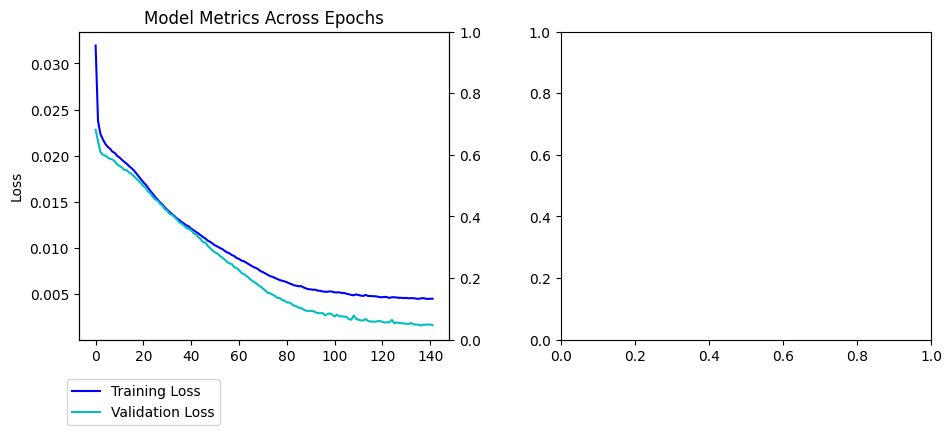

In [9]:
input_size = 4
hidden_size = 128
num_layers = 5
batch_size = 3
output_size = train_dataset.dataset.n_ahead

trainLoader = DataLoader(train_dataset, batch_size=12, num_workers=8, pin_memory=True, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=12, num_workers=8, pin_memory=True, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=True)

model = BasicLSTM(input_size, hidden_size, num_layers, output_size)

Trainer, mp = train_test_model(model, 0.001, trainLoader, validLoader, testLoader, EPOCHS=300, noPrint=False)
print(mp)

(12,) torch.Size([12, 12, 4]) torch.Size([24, 4])


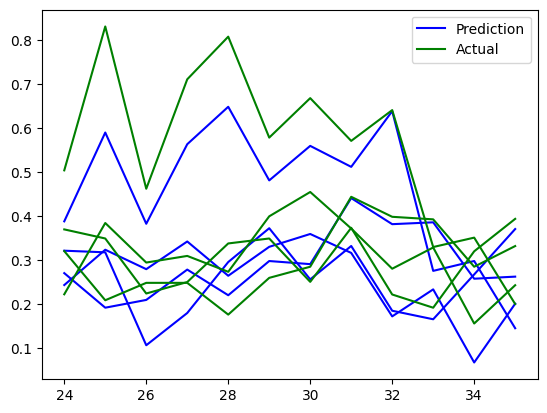

In [21]:
model_path = "./models/pre-trained/EMG_Last.pt"
model = BasicLSTM(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load(model_path))

for X, Y in testLoader:
    X = X
    Y = Y
    pred = model(X).detach().numpy()
    
    print(pred[0,:,0].shape, Y.shape, X[0].shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)

    
    # plt.plot(X[0,:].detach().cpu())
    plt.plot(y_range, pred[0,:], 'b')
    plt.plot(y_range, Y[0,:], 'g')
    
    # Create Line2D objects representing the lines
    line_pred = plt.Line2D([], [], color='blue')
    line_Y = plt.Line2D([], [], color='green')

    # Create the legend using the Line2D objects and labels
    plt.legend([line_pred, line_Y], ["Prediction", "Actual"])
    
    break

In [13]:
for x, y in trainLoader:
    print(x.shape, y.shape)
    break


torch.Size([3, 24, 4]) torch.Size([3, 12, 3])


In [11]:
len(testLoader)

60

In [9]:
max((total.values).reshape(-1))

3.962974854046147

In [10]:
torch.save(Trainer.model.state_dict(), "models/EMG_Last.pt")